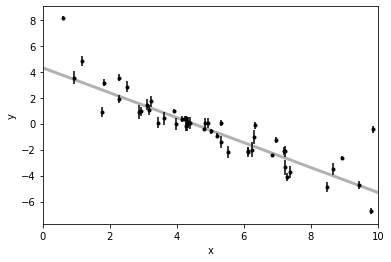

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from MCMC import EnsembleSampler
from scipy.optimize import minimize
from scipy.stats import uniform
import corner

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


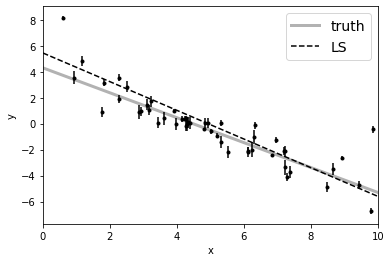

In [2]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [3]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = None, None, None
    if len(theta.shape) == 1:
        m, b, log_f = theta
        y_mod = m * x + b
        sigma2 = yerr**2 + y_mod**2 * np.exp(2 * log_f)
        return -0.5 * np.sum((y - y_mod) ** 2 / sigma2 + np.log(sigma2))
    else:
        m, b, log_f = theta[:,0], theta[:,1], theta[:,2]
        N = len(m)
        M = len(x)
        y_mod = np.repeat(m, M).reshape(N, M) * np.repeat(x, N).reshape(M, N).T + np.repeat(b, M).reshape(N, M)
        sigma2 = np.repeat(yerr**2, N).reshape(M, N).T + y_mod**2 * np.exp(2 * np.repeat(log_f, M).reshape(N, M))
        return -0.5 * np.sum((y - y_mod) ** 2 / sigma2 + np.log(sigma2), axis=1)

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


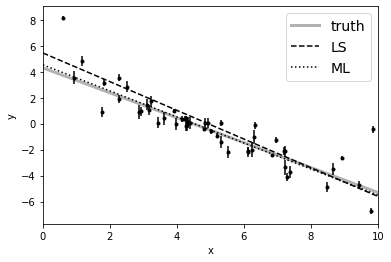

In [4]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [5]:
from scipy.stats import uniform

def log_prior(theta):
    m, b, log_f = None, None, None
    if len(theta.shape) == 1:
        m, b, log_f = theta
    else:
        m, b, log_f = theta[:,0], theta[:,1], theta[:,2]

    prob_m = uniform.pdf(m, loc=-5, scale=5.5)
    prob_b = uniform.pdf(b, loc=0, scale=10)
    prob_f = uniform.pdf(log_f, loc=-10, scale=11)
    return prob_m+prob_b+prob_f 

In [6]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape
pos.shape

(32, 3)

In [7]:
log_likelihood(pos, x, y, yerr).shape

(32,)

In [8]:
def log_probability(theta, x, y, yerr):
    log_prior_ = log_prior(theta)
    return np.select([np.isinf(log_prior_)], [-np.inf], default=log_prior_+log_likelihood(theta, x, y, yerr))

# My mcmc

100%|██████████| 5000/5000 [00:52<00:00, 95.07it/s] 


Acceptance rate:  0.64581875


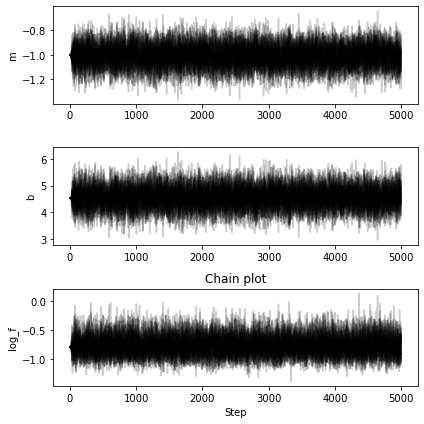

In [9]:
# from MCMC import EnsembleSampler

sampler = EnsembleSampler(ndim, nwalkers, pos, log_probability, parallel=True, args=(x, y, yerr))
sampler.run_mcmc(5000, verbose=True)
sampler.plot_chain(['m', 'b', 'log_f'])

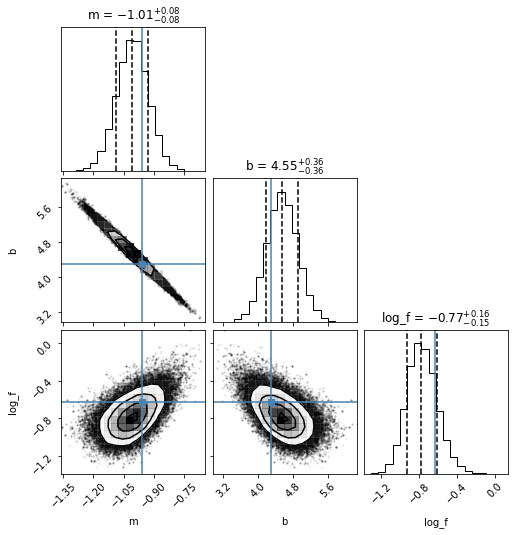

In [12]:
flat_samples = sampler.get_chain(flat=True, burn=100)

corner.corner(
    flat_samples, 
    labels=['m', 'b', 'log_f'], 
    truths=[m_true, b_true, np.log(f_true)], 
    quantiles=[0.16, 0.5, 0.84], 
    title_kwargs={"fontsize": 12},
    show_titles=True,
)
plt.show()

# EMCEE

In [13]:
# %%timeit

from multiprocessing import Pool
import os

os.environ["OMP_NUM_THREADS"] = "16"
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(x, y, yerr), pool=pool
    )
    sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [02:04<00:00, 40.32it/s]


In [ ]:
flat_samples = sampler.get_chain(discard=100, flat=True)

corner.corner(
    flat_samples, 
    labels=['m', 'b', 'log_f'], 
    truths=[m_true, b_true, np.log(f_true)], 
    quantiles=[0.16, 0.5, 0.84], 
    title_kwargs={"fontsize": 12},
    show_titles=True
)
plt.show()